In [1]:
import sys
import os
import random
import gc
import time
import torch
import numpy as np
import pandas as pd
import pickle
import ast
from tqdm import tqdm
from scipy.sparse import csr_matrix
import itertools
from scipy.stats import spearmanr, pearsonr, kendalltau, rankdata
from sklearn.metrics import ndcg_score
from transformers import AutoModelForCausalLM, AutoTokenizer
from accelerate import Accelerator
# import nltk
# nltk.download('punkt')
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from SHapRAG import *
from SHapRAG.utils import *

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df=pd.read_json("../data/musique/musique_ans_v1.0_train.jsonl", lines=True)

In [3]:
def get_titles(lst):
    # Titles where is_supporting is True
    supporting = [d['paragraph_text'] for d in lst if d.get('is_supporting') == True]
    # Titles where is_supporting is False or missing AND not already in supporting
    others = [d['paragraph_text'] for d in lst if d.get('is_supporting') != True and d['paragraph_text'] not in supporting]
    # Combine: all supporting + as many others as needed to reach 10
    result = supporting + others
    return result[:10]

df.paragraphs=df.paragraphs.apply(get_titles)

In [4]:
SEED = 42
# Initialize Accelerator
accelerator_main = Accelerator(mixed_precision="fp16")

# Load Model
if accelerator_main.is_main_process:
    print("Main Script: Loading model...")
model_path = "mistralai/Mistral-7B-Instruct-v0.3"
# model_path = "meta-llama/Llama-3.1-8B-Instruct"
# model_path = "Qwen/Qwen2.5-3B-Instruct"

model_cpu = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model_cpu.config.pad_token_id = tokenizer.pad_token_id
    if hasattr(model_cpu, 'generation_config') and model_cpu.generation_config is not None:
        model_cpu.generation_config.pad_token_id = tokenizer.pad_token_id

if accelerator_main.is_main_process:
    print("Main Script: Preparing model with Accelerator...")
prepared_model = accelerator_main.prepare(model_cpu)
unwrapped_prepared_model = accelerator_main.unwrap_model(prepared_model)
unwrapped_prepared_model.eval()
if accelerator_main.is_main_process:
    print("Main Script: Model prepared and set to eval.")

# Define utility cache

accelerator_main.wait_for_everyone()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Main Script: Loading model...


Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Main Script: Preparing model with Accelerator...
Main Script: Model prepared and set to eval.


In [5]:
num_questions_to_run = 50
k_values = [1, 2, 3, 4, 5]
all_results = []
extras = []
def gtset_k():
    return [0, 1,2,3,5]
for i in range(num_questions_to_run):
    i=i+19850
    query = df.question[i]
    if accelerator_main.is_main_process:
        print(f"\n--- Question {i+1}/{num_questions_to_run}: {query[:60]}... ---")

    docs = df.paragraphs[i]
    utility_cache_base_dir = f"../Experiment_data/musique/{model_path.split('/')[1]}/four/"
    utility_cache_filename = f"utilities_q_idx{i}.pkl"
    current_utility_path = os.path.join(utility_cache_base_dir, utility_cache_filename)

    if accelerator_main.is_main_process:
        os.makedirs(os.path.dirname(current_utility_path), exist_ok=True)

    harness = ContextAttribution(
        items=docs,
        query=query,
        prepared_model=prepared_model,
        prepared_tokenizer=tokenizer,
        accelerator=accelerator_main,
        utility_cache_path=current_utility_path
    )
    
    
    # res = evaluate(df.question[i], harness.target_response, df.answer[i])
    # res='True'
    if accelerator_main.is_main_process:
        methods_results = {}
        metrics_results = {}
        extra_results = {}

        m_samples_map = {"XS": 32, "S":64, "M":128, "L":264, "XL":528, "XXL":724, "XXXL":1024}

        # Store FM models for later R²/MSE
        fm_models = {}
        methods_results['Exact-Shap']=harness._calculate_shapley()
        for size_key, actual_samples in m_samples_map.items():
            print(f"Running sample size: {actual_samples}")
            methods_results[f"ContextCite_{actual_samples}"], fm_models[f"ContextCite_{actual_samples}"] = harness.compute_contextcite(
                num_samples=actual_samples, seed=SEED
            )
            # FM Weights (loop over ranks 0–5)
            # for rank in [1,2,4,8]:
                # methods_results[f"FM_WeightsLK_{rank}_{actual_samples}"], extra_results[f"Flk_{rank}_{actual_samples}"], fm_models[f"FM_WeightsLK_{rank}_{actual_samples}"] = harness.compute_wss(
                #     num_samples=actual_samples,
                #     seed=SEED,
                #     sampling="kernelshap",
                #     sur_type="fm",
                #     rank=rank
                # )
            methods_results[f"FMW_{actual_samples}"], extra_results[f"FMW_{actual_samples}"], fm_models[f"FMW_{actual_samples}"] = harness.compute_wss(
                        num_samples=actual_samples,
                        seed=SEED,
                        sampling="kernelshap",
                        sur_type="fmsgd")
            methods_results[f"FM_{actual_samples}"], extra_results[f"FM_{actual_samples}"], fm_models[f"FM_{actual_samples}"] = harness.compute_wss(
                    num_samples=actual_samples,
                    seed=SEED,
                    sampling="kernelshap",
                    sur_type="fm")
            
            # methods_results[f"FM_u_dynamic_{actual_samples}"], extra_results[f"FM_u_dynamic_{actual_samples}"], fm_models[f"FM_u_dynamic_{actual_samples}"] = harness.compute_wss_dynamic_pruning_reuse_utility(num_samples=actual_samples)
            # methods_results[f"FM_k_dynamic_{actual_samples}"], extra_results[f"FM_k_dynamic_{actual_samples}"], fm_models[f"FM_k_dynamic_{actual_samples}"] = harness.compute_wss_dynamic_pruning_reuse_utility(num_samples=actual_samples, initial_rank=1, final_rank=2)
            # methods_results[f"FM_k_dynamice_{actual_samples}"], extra_results[f"FM_k_dynamice_{actual_samples}"], fm_models[f"FM_k_dynamice_{actual_samples}"] = harness.compute_wss_dynamic_pruning_reuse_utility(num_samples=actual_samples, initial_rank=1, pruning_strategy='elbow')
            try:
                # attributionsspex, interactionspex = harness.compute_spex(sample_budget=actual_samples, max_order=2)
                attributionshap, interactionshap, fm_models[f"FSII_{actual_samples}"] = harness.compute_fsii(sample_budget=actual_samples, max_order=harness.n_items)
                # attributionban, interactionban, fm_models[f"FBII_{actual_samples}"] = harness.compute_fbii(sample_budget=actual_samples, max_order=harness.n_items)
                # methods_results[f"FBII_{actual_samples}"] = attributionban
                methods_results[f"FSII_{actual_samples}"] = attributionshap
                # methods_results[f"Spex_{actual_samples}"] = attributionsspex


                extra_results.update({
                f"Int_FSII_{actual_samples}":interactionshap
                # f"Int_FBII_{actual_samples}":interactionban,
                # f"Int_Spex_{actual_samples}":interactionspex
                })
            except Exception: pass


    #     methods_results["LOO"] = harness.compute_loo()
    #     methods_results["ARC-JSD"] = harness.compute_arc_jsd()
        attributionxs, interactionxs, fm_models["Exact-FSII"] = harness.compute_exact_fsii(max_order=2)

        extra_results.update({
        "Exact-FSII": interactionxs
    })
        methods_results["Exact-FSII"]=attributionxs

        # --- Evaluation Metrics ---
        metrics_results["topk_probability"] = harness.evaluate_topk_performance(
            methods_results, fm_models, k_values
        )

        # R²
        metrics_results["R2"] = harness.r2(methods_results,100,mode='log-perplexity', models=fm_models)
        metrics_results['Recall']=harness.recall_at_k(gtset_k(), methods_results, k_values)
        metrics_results["Delta_R2"] = harness.delta_r2(methods_results,100,mode='log-perplexity', models=fm_models)

        # LDS per method
        metrics_results["LDS"] = harness.lds(methods_results,20,mode='log-perplexity', models=fm_models)



        all_results.append({
            "query_index": i,
            "query": query,
            "ground_truth": df.answer[i],
            "response": harness.target_response,
            "methods": methods_results,
            "metrics": metrics_results
        })
        extras.append(extra_results)



--- Question 19851/50: What county shares border with another county adjacent to th... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Mistral-7B-Instruct-v0.3/four/utilities_q_idx19850.pkl...
Successfully loaded 1024 cached utility entries.


2025-11-17 09:41:20.198620: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-17 09:41:20.267313: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-17 09:41:21.926952: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Running sample size: 32
Best rank selected: 4
[fastFM] Selected rank=1
Running sample size: 64
Best rank selected: 8
[fastFM] Selected rank=1
Running sample size: 128
Best rank selected: 8
[fastFM] Selected rank=2
Running sample size: 264
Best rank selected: 1
[fastFM] Selected rank=4
SPEX approximation completed.
Running sample size: 528
Best rank selected: 2
[fastFM] Selected rank=8
SPEX approximation completed.
Running sample size: 724
Best rank selected: 4
[fastFM] Selected rank=8
SPEX approximation completed.
Running sample size: 1024
Best rank selected: 8
[fastFM] Selected rank=8
SPEX approximation completed.
Computing actual utility deltas for 488 (subset, player) pairs...
Computing delta R² for Exact-Shap...
Exact-Shap delta R² score: 0.6150
Computing delta R² for ContextCite_32...
ContextCite_32 delta R² score: 0.5140
Computing delta R² for FMW_32...
FMW_32 delta R² score: 0.1548
Computing delta R² for FM_32...
FM_32 delta R² score: -0.6934
Computing delta R² for ContextCite_6

KeyboardInterrupt: 

In [ ]:
harness.utility_cache

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ndcg_score
import numpy as np

spearmans = {i: [] for i in all_results[0]['methods'] if i != "Exact-Shap"}
scaler = MinMaxScaler()

for method_res in all_results:
    for method, attribution in method_res['methods'].items():
        if method != "Exact-Shap":
            # Convert to numpy arrays for scaling
            ref = np.array(method_res['methods']["Exact-Shap"]).reshape(-1, 1)
            att = np.array(attribution).reshape(-1, 1)
            
            # Scale both reference and attribution to [0, 1]
            ref_scaled = scaler.fit_transform(ref).flatten()
            att_scaled = scaler.fit_transform(att).flatten()
            
            # Compute NDCG score
            spear = ndcg_score([ref_scaled], [att_scaled], k=4)
            spearmans[method].append(spear)


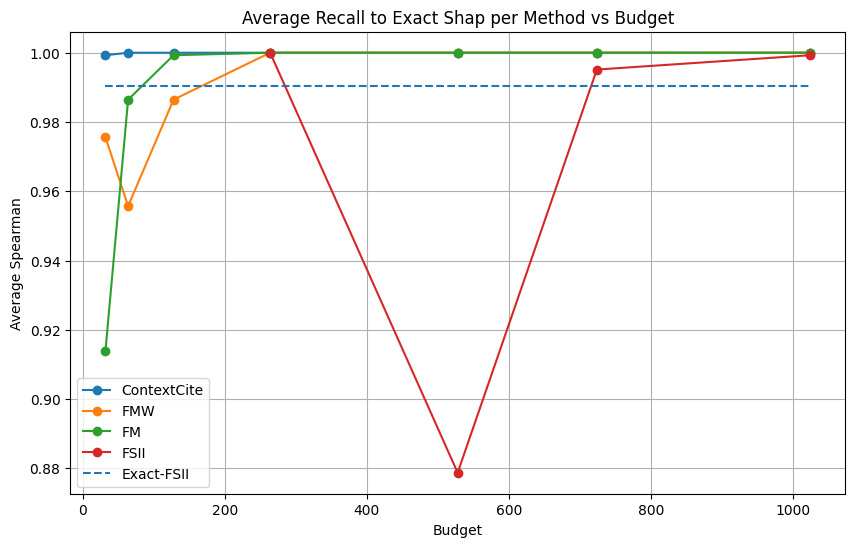

In [7]:
import re
import numpy as np
import matplotlib.pyplot as plt

# Parse methods and budgets
parsed = {}
budgets = set()
for key, values in spearmans.items():
    avg_val = np.mean(values)
    
    match = re.match(r"(.+?)_(\d+)$", key)  # method_budget pattern
    if match:
        method, budget = match.groups()
        budget = int(budget)
        budgets.add(budget)
        parsed.setdefault(method, {})[budget] = avg_val
    else:
        # constant methods (no budget)
        parsed.setdefault(key, {})[None] = avg_val

budgets = sorted(budgets)

# Plot
plt.figure(figsize=(10,6))

for method, results in parsed.items():
    if None in results:  # constant method
        plt.hlines(results[None], xmin=min(budgets), xmax=max(budgets), 
                   linestyles='--', label=method)
    else:
        xs = sorted(results.keys())
        ys = [results[b] for b in xs]
        plt.plot(xs, ys, marker='o', label=method)

plt.xlabel("Budget")
plt.ylabel("Average Spearman")
plt.title("Average Recall to Exact Shap per Method vs Budget")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
import pandas as pd
import numpy as np
from collections import defaultdict

def summarize_and_print(all_results, k_values=[1, 2, 3,4,5]):
    table_data = defaultdict(lambda: defaultdict(list))

    # Mapping for consistency
    method_name_map = {
        
    }

    for res in all_results:
        metrics = res["metrics"]
        # LDS and R2
        for method_name, lds_val in metrics.get("LDS", {}).items():
            method = method_name_map.get(method_name, method_name)
            table_data[method]["LDS"].append(lds_val)

        for method_name, r2_val in metrics.get("R2", {}).items():
            method = method_name_map.get(method_name, method_name)
            table_data[method]["R2"].append(r2_val)

        # Delta R2 (new)
        for method_name, delta_val in metrics.get("Delta_R2", {}).items():
            method = method_name_map.get(method_name, method_name)
            table_data[method]["Delta_R2"].append(delta_val)

        # Top-k
        for method_name, k_dict in metrics.get("topk_probability", {}).items():
            method = method_name_map.get(method_name, method_name)
            for k in k_values:
                if k in k_dict:
                    col_name = f"topk_probability_k{k}"
                    table_data[method][col_name].append(k_dict[k])
        
        for method_name, k_dict in metrics.get("Recall", {}).items():
            method = method_name_map.get(method_name, method_name)
            for k in k_values:
                col_name = f"Recall@{k}"
                table_data[method][col_name].append(k_dict[k-1])

    # Averages
    avg_table = {
        method: {metric: np.nanmean(values) for metric, values in metric_dict.items()}
        for method, metric_dict in table_data.items()
    }

    # Standard deviations for LDS, R², and Delta_R2
    for method, metric_dict in table_data.items():
        for metric in ["LDS", "R2", "Delta_R2"]:
            if metric in metric_dict:
                avg_table[method][f"{metric}_std"] = np.nanstd(metric_dict[metric])

    df_summary = pd.DataFrame.from_dict(avg_table, orient="index").sort_index()

    print("\n=== Metrics Summary Across All Queries ===")
    print(df_summary.to_string(float_format="%.4f"))

    return df_summary
df_res=summarize_and_print(all_results, k_values=[1, 2, 3,4,5])



=== Metrics Summary Across All Queries ===
                  LDS     R2  Delta_R2  topk_probability_k1  topk_probability_k2  topk_probability_k3  topk_probability_k4  topk_probability_k5  Recall@1  Recall@2  Recall@3  Recall@4  Recall@5  LDS_std  R2_std  Delta_R2_std
ContextCite_1024  NaN 0.9522    0.5539               0.4740               0.9046               1.3476               1.5577               1.7791    0.2000    0.4000    0.6000    0.8000    1.0000      NaN  0.0000        0.0000
ContextCite_128   NaN 0.9599    0.5793               0.4740               0.9046               1.3476               1.5577               1.8075    0.2000    0.4000    0.6000    0.8000    0.8000      NaN  0.0000        0.0000
ContextCite_264   NaN 0.9576    0.5746               0.4740               0.9046               1.3476               1.5577               1.7791    0.2000    0.4000    0.6000    0.8000    1.0000      NaN  0.0000        0.0000
ContextCite_32    NaN 0.9685    0.5140               0.4

/tmp/ipykernel_3428411/111847886.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_budgeted['family'] = df_budgeted['method'].apply(lambda x: "_".join(x.split("_")[:-1]))
/tmp/ipykernel_3428411/111847886.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_budgeted['budget'] = df_budgeted['method'].apply(lambda x: int(x.split("_")[-1]))


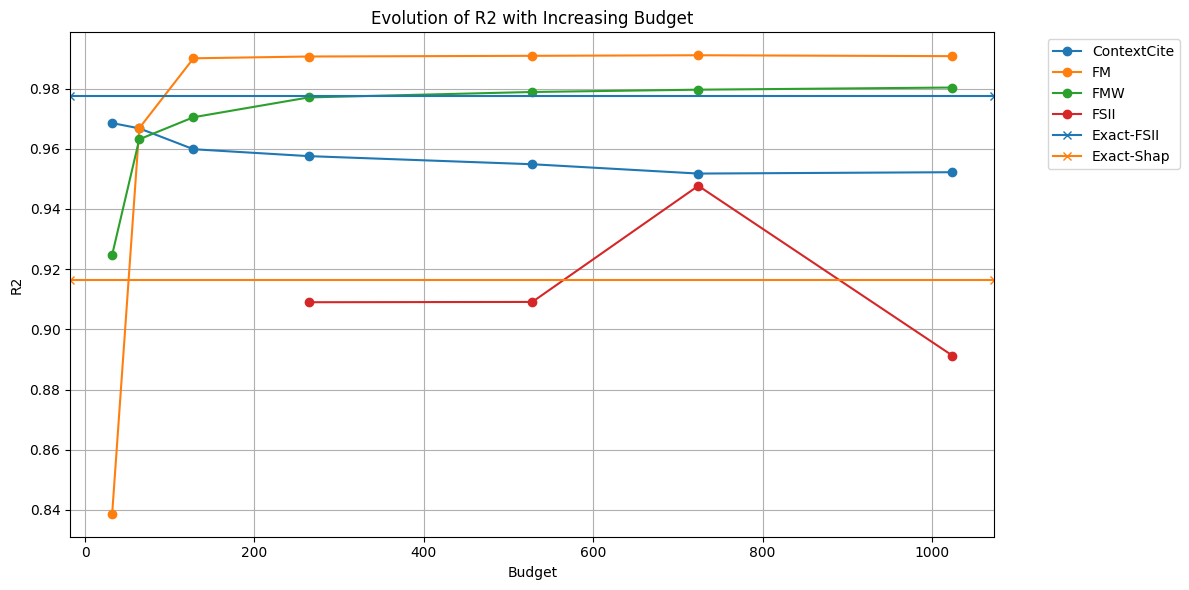

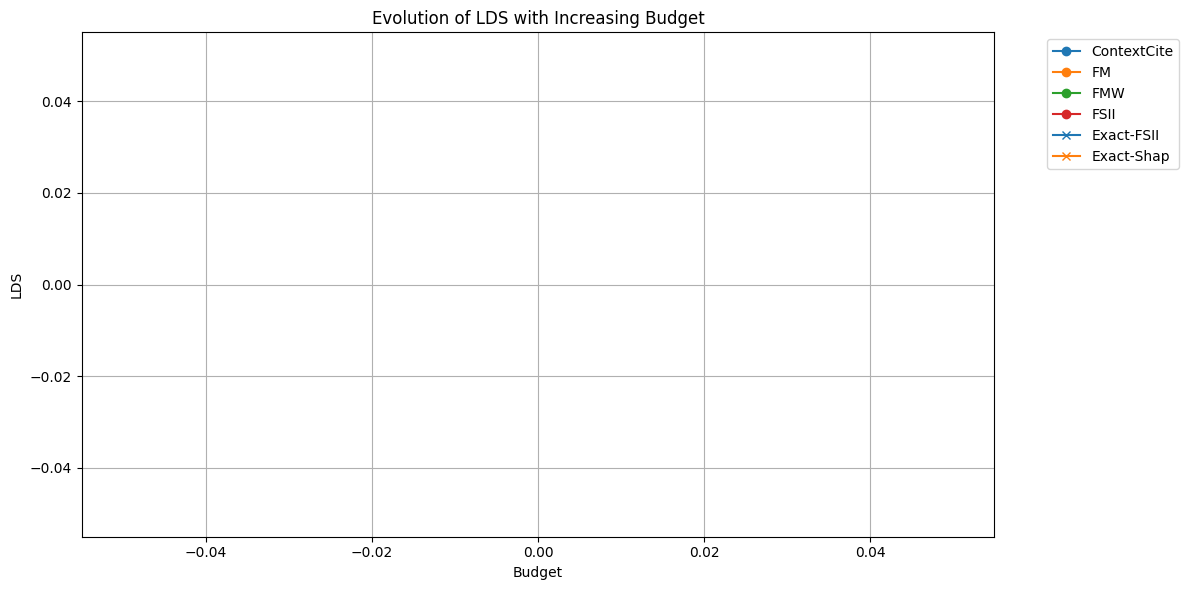

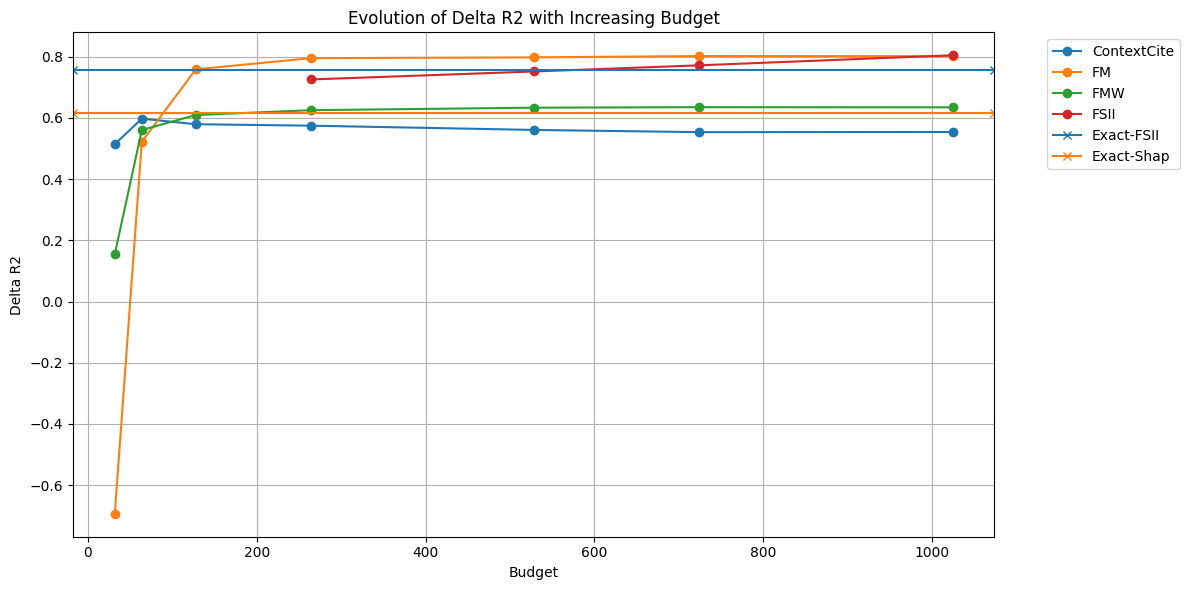

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Reset index
df_reset = df_res.reset_index().rename(columns={'index': 'method'})

# Separate constant methods (no budget) and budgeted methods
constant_methods = ['LOO', 'ARC-JSD', 'Exact-FSII', 'Exact-Shap']
df_const = df_reset[df_reset['method'].isin(constant_methods)]
df_budgeted = df_reset[~df_reset['method'].isin(constant_methods)]

# Extract family and budget for budgeted methods
df_budgeted['family'] = df_budgeted['method'].apply(lambda x: "_".join(x.split("_")[:-1]))
df_budgeted['budget'] = df_budgeted['method'].apply(lambda x: int(x.split("_")[-1]))
df_budgeted = df_budgeted.sort_values(by=['family', 'budget'])

# Function to plot metric
def plot_metric(metric, ylabel):
    plt.figure(figsize=(12, 6))

    # Plot budgeted families
    families = df_budgeted['family'].unique()
    for fam in families:
        # if 'LK' not in fam:
        subset = df_budgeted[df_budgeted['family'] == fam]
        plt.plot(subset['budget'], subset[metric], marker='o', label=fam)

    # Plot constant methods as horizontal lines
    colors = plt.cm.tab10.colors  # categorical palette
    for idx, (_, row) in enumerate(df_const.iterrows()):
        plt.axhline(y=row[metric], color=colors[idx % len(colors)],marker='x', label=row['method'])

    plt.xlabel("Budget")
    plt.ylabel(ylabel)
    plt.title(f"Evolution of {ylabel} with Increasing Budget")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metric("R2", "R2")
plot_metric("LDS", "LDS")
plot_metric("Delta_R2", "Delta R2")


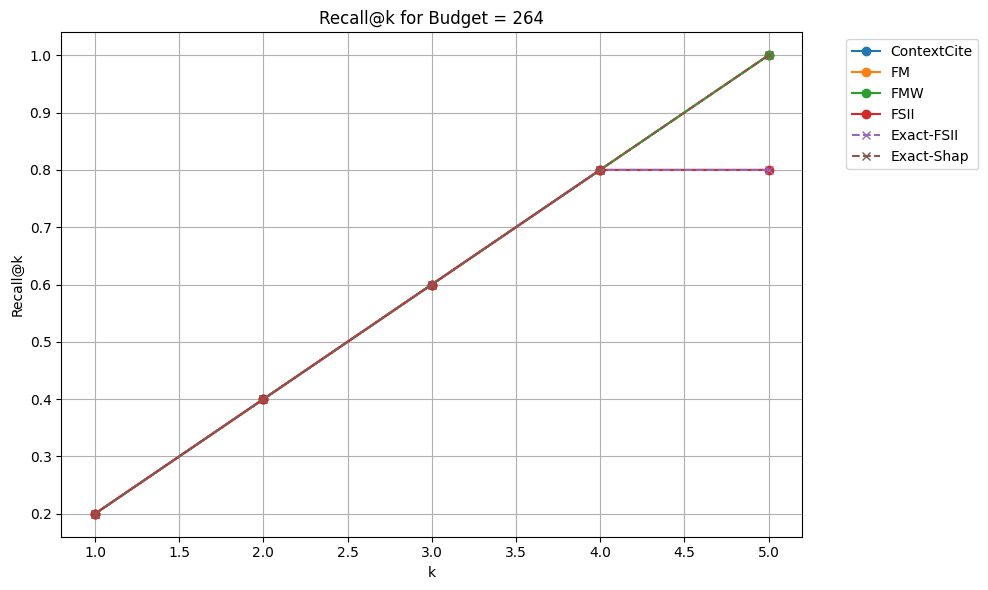

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter budgeted methods at budget = 274
df_budgeted_264 = df_budgeted[df_budgeted['budget'] == 1024]

# Metrics to plot
recall_metrics = [f"Recall@{k}" for k in range(1, 6)]
k_values = list(range(1, 6))

plt.figure(figsize=(10, 6))

# Plot budgeted families at budget 274
families = df_budgeted_264['family'].unique()
for fam in families:
    # if 'LK' not in fam:
    subset = df_budgeted_264[df_budgeted_264['family'] == fam]
    if not subset.empty:
        recalls = subset[recall_metrics].values.flatten()
        plt.plot(k_values, recalls, marker='o', label=fam)

# Plot constant methods
for idx, (_, row) in enumerate(df_const.iterrows()):
    recalls = [row[m] for m in recall_metrics]
    plt.plot(k_values, recalls, marker='x', linestyle="--", label=row['method'])

plt.xlabel("k")
plt.ylabel("Recall@k")
plt.title("Recall@k for Budget = 264")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


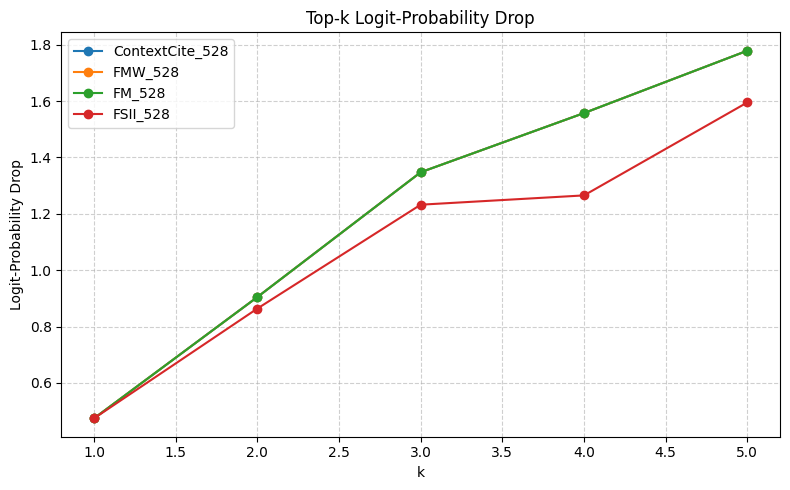

In [13]:
plt.figure(figsize=(8, 5))
for method in df_res.index:
    if "528" in method :
        plt.plot(
            [1, 2, 3,4,5],
            df_res.loc[method, ['topk_probability_k1', 'topk_probability_k2', 'topk_probability_k3', 'topk_probability_k4', 'topk_probability_k5']],
            marker='o',
            label=method
        )

plt.xlabel('k')
plt.ylabel('Logit-Probability Drop')
plt.title('Top-k Logit-Probability Drop')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 1. Exact match with human labels

In [14]:
import numpy as np

def evaluate_methods(extras, k, m, interaction_type="max"):

    methods = extras[0].keys()
    scores = {m: 0 for m in methods}
    n_experiments = len(extras)

    for exp in extras:
        for method in methods:
            if "Fl" in method or "FM" in method:
                # Flu is a matrix
                value = exp[method][k][m]
                all_values = exp[method].flatten()
            else:
                # Dictionaries with tuple keys
                d = exp[method]
                value = None
                for key, v in d.items():
                    if key == (k, m):
                        value = v
                        break
                if value is None:
                    continue  # skip if (k,m) not found
                all_values = list(d.values())

            if interaction_type == "max":
                if value == max(all_values):
                    scores[method] += 1
            elif interaction_type == "min":
                if value == min(all_values):
                    scores[method] += 1

    # Convert to fraction of experiments
    results = {method: scores[method] / n_experiments for method in methods}
    return results

In [15]:
# Recovery rate
em={}
for i, j in enumerate(np.array(list(evaluate_methods(extras, k=1, m=5, interaction_type="min").values()))):
    em.update({list(extras[0].keys())[i]:j})

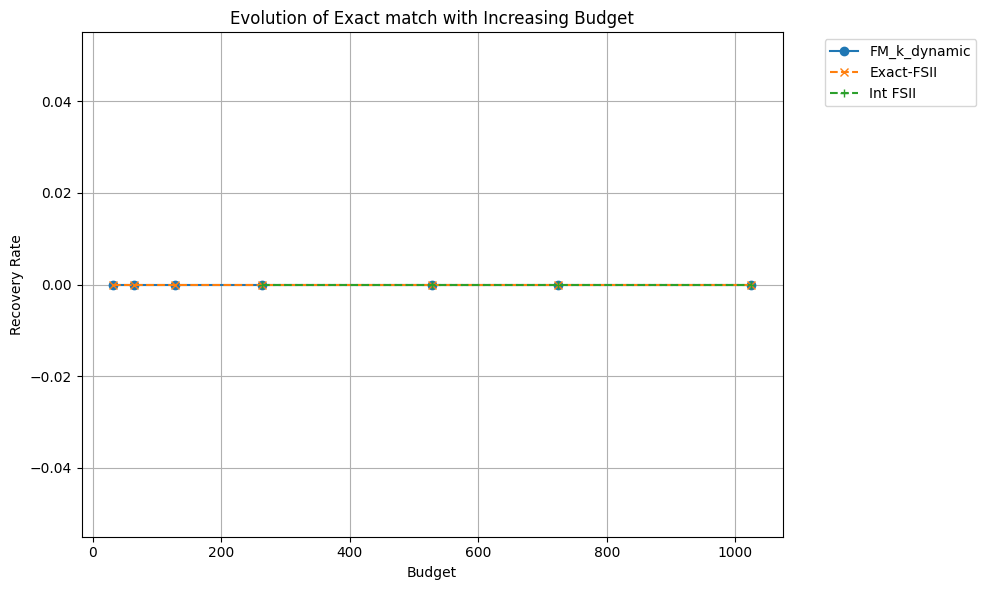

In [16]:
rows = []
for k, v in em.items():
    parts = k.split("_")
    if parts[0] == "Flk" and parts[1]!='0':
        _, rank, budget = parts
        rows.append({"method": "Flk", "rank": int(rank), "budget": int(budget), "recovery": v})
    elif parts[0] == "FM":
        _,budget = parts
        rows.append({"method": f'FM_k_dynamic', "budget": int(budget), "recovery": v})
    elif parts[0] == "Int":
        _, name, budget = parts
        rows.append({"method": name, "budget": int(budget), "recovery": v})

df = pd.DataFrame(rows)

# Plot
plt.figure(figsize=(10, 6))

# Plot Flu (different ranks as lines)
# for rank in sorted(df[df["method"]=="Flk"]["rank"].unique()):
#     sub = df[(df["method"]=="Flk") & (df["rank"]==rank)].sort_values("budget")
#     plt.plot(sub["budget"], sub["recovery"]/3, marker="o", label=f"Flk rank {rank}")

# for rank in sorted(df[df["method"]=="FM_k_dynamic"]["rank"].unique()):
#     sub = df[(df["method"]=="FM_k_dynamic") & (df["rank"]==rank)].sort_values("budget")
#     plt.plot(sub["budget"], sub["recovery"]/3, marker="o", label=f"FM_k_dynamic rank {rank}")
# for rank in sorted(df[df["method"]=="FM_r_dynamic"]):
sub1 = df[(df["method"]=="FM_k_dynamic")].sort_values("budget")
plt.plot(sub1["budget"], sub1["recovery"]/3, marker="o", label=f"FM_k_dynamic")
plt.plot(sub1["budget"],em['Exact-FSII']*np.ones(7)/3, marker="x", linestyle="--", label=f"Exact-FSII")

# Plot Int methods (evolve with budget, start at 264)
for m in df[df["method"].isin(["FSII","FBII","Spex"])]['method'].unique():
    sub = df[df["method"]==m].sort_values("budget")
    plt.plot(sub["budget"], sub["recovery"]/3, marker="+", linestyle="--", label=f"Int {m}")



plt.xlabel("Budget")
plt.ylabel("Recovery Rate")
plt.title("Evolution of Exact match with Increasing Budget")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. RR@k

In [17]:
def compute_rr_at_k(interaction, ground_truth, k):
    """
    Compute Recovery@k for a method's interaction dict or matrix.
    interaction: dict {(i, j): value} or 2D numpy array/matrix
    ground_truth: set of ground-truth indices (R^*)
    k: number of top interactions to consider
    Returns: RR@k value
    """
    # Convert matrix to dict if needed
    if isinstance(interaction, (np.ndarray, list)):
        mat = np.array(interaction)
        pairs = {(i, j): mat[i][j] for i in range(mat.shape[0]) for j in range(mat.shape[1]) if i != j}
    else:
        pairs = interaction

    # Sort pairs by value (descending)
    sorted_pairs = sorted(pairs.items(), key=lambda x: x[1], reverse=True)
    rr_sum = 0.0
    for i in range(min(k, len(sorted_pairs))):
        pair_indices = set(sorted_pairs[i][0])
        rr_sum += len(ground_truth & pair_indices) / len(pair_indices)
    return rr_sum / k if k > 0 else 0.0

In [18]:
ground_truth = set([0, 1,2,3,5])  # Example ground-truth indices
k = 5  # Number of top interactions to consider

rr_results = {}
for method, interaction in extras[0].items():  # Use the correct experiment index
    rr_results[method] = compute_rr_at_k(interaction, ground_truth, k)

print(rr_results)

{'FMW_32': 0.7, 'FM_32': 0.3, 'FMW_64': 0.4, 'FM_64': 0.8, 'FMW_128': 0.2, 'FM_128': 0.4, 'FMW_264': 0.2, 'FM_264': 0.5, 'Int_FSII_264': 0.2, 'FMW_528': 0.4, 'FM_528': 0.3, 'Int_FSII_528': 0.7, 'FMW_724': 0.4, 'FM_724': 0.6, 'Int_FSII_724': 0.6, 'FMW_1024': 0.4, 'FM_1024': 0.6, 'Int_FSII_1024': 0.3, 'Exact-FSII': 0.5}


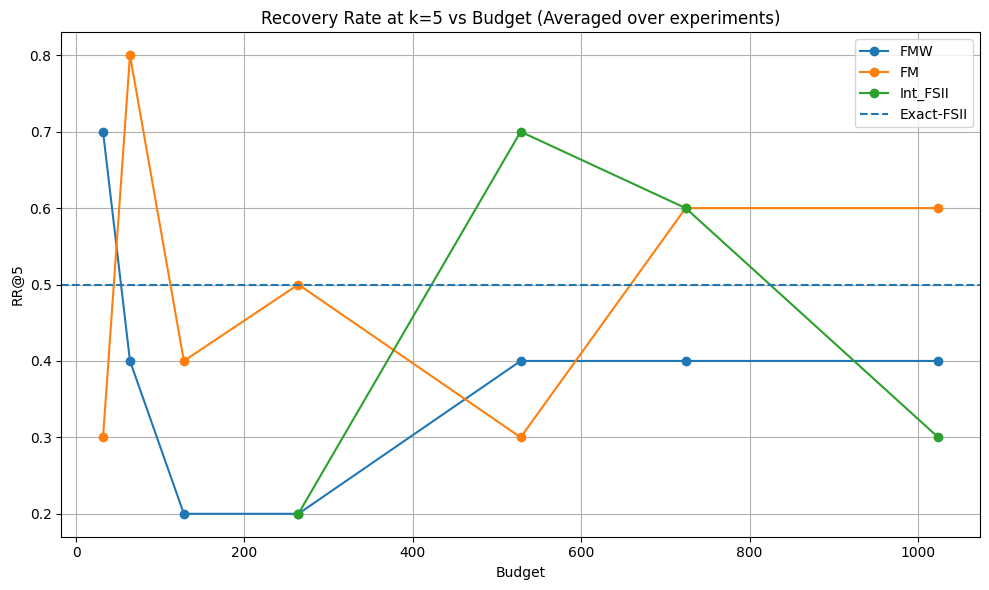

In [19]:
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Parse RR@k for all experiments and budgets
def extract_budget(key):
    match = re.search(r'_(\d+)$', key)
    return int(match.group(1)) if match else None

def extract_family(key):
    if key.startswith("FM_"):
        return "FM"
    elif key.startswith("FMW"):
        return "FMW"
    elif key.startswith("Int_FSII"):
        return "Int_FSII"
    elif key.startswith("Flk"):
        return key.split("_")[0]+"_"+key.split("_")[1]
    elif key.startswith("Int_FBII"):
        return "Int_FBII"
    return None

def collect_rr_at_k_over_budgets(extras, ground_truth, k):
    # For each experiment, for each method, collect RR@k by budget
    rr_by_method_budget = defaultdict(lambda: defaultdict(list))
    for exp in extras:
        for method, interaction in exp.items():
            budget = extract_budget(method)
            family = extract_family(method)
            if budget and family:
                rr = compute_rr_at_k(interaction, ground_truth, k)
                rr_by_method_budget[family][budget].append(rr)
    # Average over experiments
    rr_avg = defaultdict(dict)
    for family, budgets in rr_by_method_budget.items():
        for budget, vals in budgets.items():
            rr_avg[family][budget] = np.mean(vals)
    return rr_avg
rr_avg = collect_rr_at_k_over_budgets(extras, ground_truth, k)
# Plot RR@k as line chart for each method family, with constant methods as parallel lines
plt.figure(figsize=(10, 6))

# Plot budgeted families
for family, budget_rrs in rr_avg.items():
    budgets = sorted(budget_rrs.keys())
    values = [budget_rrs[b] for b in budgets]
    plt.plot(budgets, values, marker='o', label=family)

# Plot constant methods (e.g., Exact-FSII, LOO, ARC-JSD) as horizontal lines
constant_methods = ['Exact-FSII', 'LOO', 'ARC-JSD']
for method in constant_methods:
    # Collect RR@k for each experiment and average
    rr_vals = []
    for exp in extras:
        if method in exp:
            rr_vals.append(compute_rr_at_k(exp[method], ground_truth, k))
    if rr_vals:
        avg_rr = np.mean(rr_vals)
        plt.axhline(y=avg_rr, color=None, linestyle='--', label=method)

plt.xlabel('Budget')
plt.ylabel(f'RR@{k}')
plt.title(f'Recovery Rate at k={k} vs Budget (Averaged over experiments)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 3. NDCG to Exact-FSII

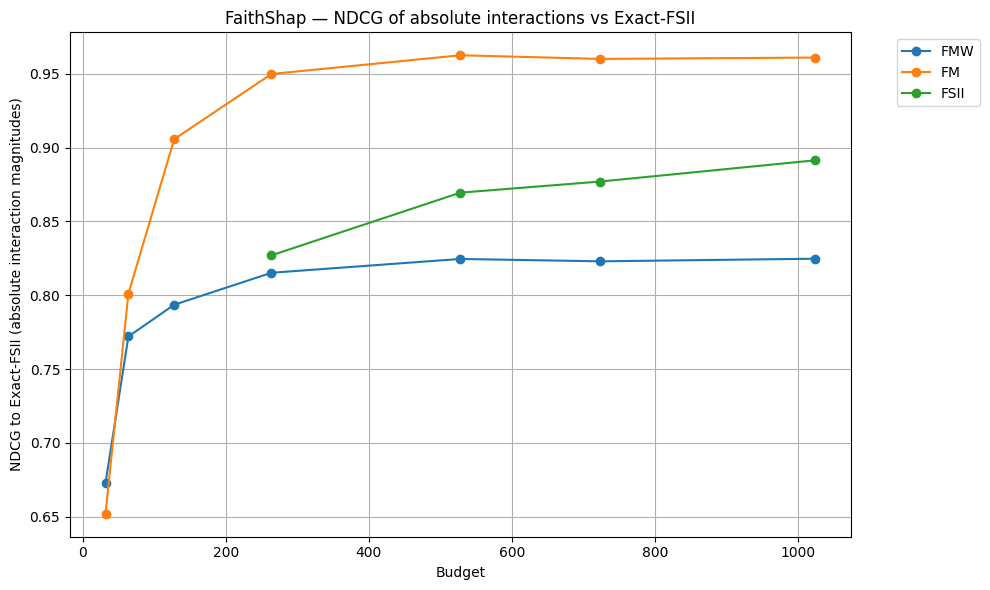

In [15]:
# FaithShap (absolute values) → NDCG plotting
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import ndcg_score

def extract_budget(key):
    m = re.search(r'_(\d+)$', key)
    return int(m.group(1)) if m else None

def extract_family(key):
    # Map method keys to families used in earlier plots
    if key.startswith("FM_"):
        return "FM"
    elif key.startswith("FMW"):
        return "FMW"
    if key.startswith("Flk_"):
        # collapse to Flu/Flk family prefix (keep as-is for plotting)
        parts = key.split("_")
        return parts[0]+parts[1] if parts else None
    if key.startswith("Int_FSII") or key.startswith("FSII"):
        return "FSII"
    if key.startswith("Int_FBII") or key.startswith("FBII"):
        return "FBII"
    return None

def pairs_from_exact(exp_list):
    # Find a canonical pair ordering from Exact-FSII of the first experiment that has it
    for exp in exp_list:
        exact = exp.get('Exact-FSII')
        if exact and isinstance(exact, dict):
            return sorted(exact.keys())
    # fallback: try to infer from any dict-valued method
    for exp in exp_list:
        for v in exp.values():
            if isinstance(v, dict) and v:
                return sorted(v.keys())
    return []

def vector_for_pairs(val, pairs):
    # val can be dict {(i,j):score} or a square matrix/list/ndarray
    if isinstance(val, (list, np.ndarray)):
        mat = np.array(val)
        return [abs(mat[i][j]) if (0 <= i < mat.shape[0] and 0 <= j < mat.shape[1]) else 0.0 for (i,j) in pairs]
    elif isinstance(val, dict):
        return [abs(val.get(pair, 0.0)) for pair in pairs]
    else:
        # Unknown type -> zeros
        return [0.0 for _ in pairs]

# Build canonical pair list
pairs = pairs_from_exact(extras)
if not pairs:
    print('No pair ordering could be inferred from Exact-FSII or other dicts in extras. Aborting NDCG computation.')
else:
    # Compute per-experiment NDCG scores for each method (relative to Exact-FSII)
    per_method_ndcg = defaultdict(list)
    for exp in extras:
        exact = exp.get('Exact-FSII', {})
        exact_vec = vector_for_pairs(exact, pairs)
        # if exact vector is all zeros, skip this experiment for fairness
        if np.allclose(exact_vec, 0.0):
            continue
        for method, val in exp.items():
            if method == 'Exact-FSII':
                continue
            try:
                vec = vector_for_pairs(val, pairs)
                # ndcg_score expects shape (n_samples, n_labels) for both y_true and y_score
                score = ndcg_score([exact_vec], [vec])
                per_method_ndcg[method].append(score)
            except Exception:
                # skip methods we cannot convert
                continue

    # Average NDCG across experiments for each method
    avg_ndcg = {m: float(np.mean(scores)) for m, scores in per_method_ndcg.items() if len(scores)>0}

    # Group budgeted methods by family and budget
    family_budget = defaultdict(lambda: defaultdict(list))
    for method, score in avg_ndcg.items():
        budget = extract_budget(method)
        family = extract_family(method)
        if budget is not None and family is not None:
            family_budget[family][budget].append(score)

    # Compute mean per family-budget (in case multiple variant keys map to same family-budget)
    family_budget_avg = {}
    for fam, bd in family_budget.items():
        family_budget_avg[fam] = {b: float(np.mean(vals)) for b, vals in bd.items()}

    # Plotting: line per family (budgeted), horizontal lines for constant methods
    plt.figure(figsize=(10,6))
    # Plot budgeted families
    for fam, bd in family_budget_avg.items():
        xs = sorted(bd.keys())
        ys = [bd[x] for x in xs]
        plt.plot(xs, ys, marker='o', label=fam)

    # Constant methods: plot as horizontal lines using avg_ndcg if available
    constant_methods = ['Exact-FSII','Exact-Shap','LOO','ARC-JSD']
    for cm in constant_methods:
        if cm in avg_ndcg:
            plt.axhline(y=avg_ndcg[cm], linestyle='--', label=cm)

    plt.xlabel('Budget')
    plt.ylabel('NDCG to Exact-FSII (absolute interaction magnitudes)')
    plt.title('FaithShap — NDCG of absolute interactions vs Exact-FSII')
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()